INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


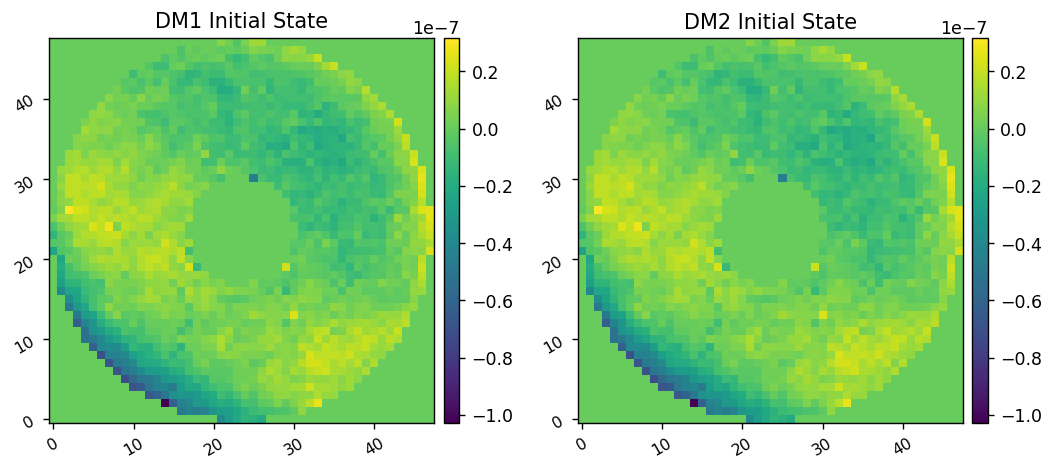

In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

imshow2(dm1_flat/2, dm2_flat/2, 'DM1 Initial State', 'DM2 Initial State', cmap1='viridis', cmap2='viridis')

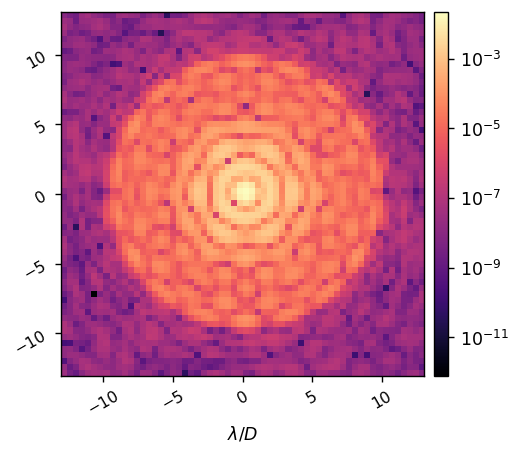

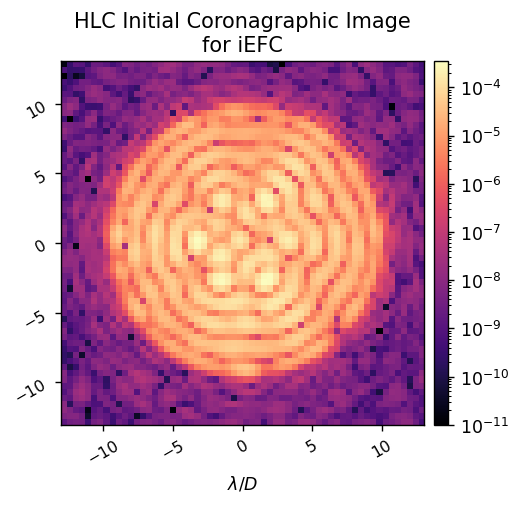

In [4]:
reload(cgi_phasec_poppy)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='hlc', npsf=60,
                                dm1_ref=dm1_flat,
                                dm2_ref=dm2_flat,
                              use_pupil_defocus=True, 
                              use_opds=True)

mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'HLC Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

# Create dark hole ROI to calibrate and control

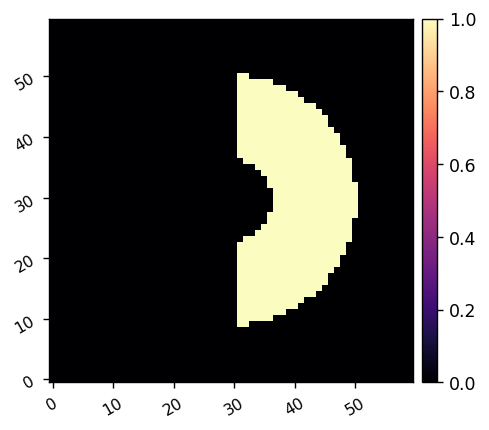

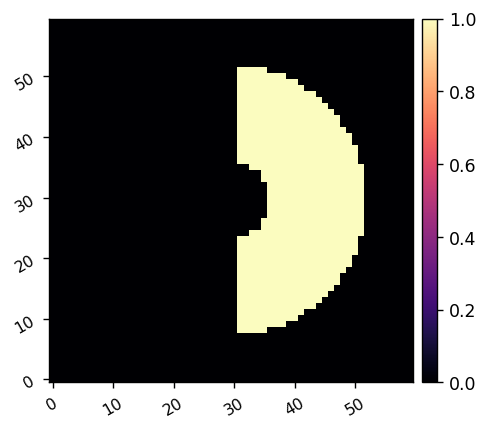

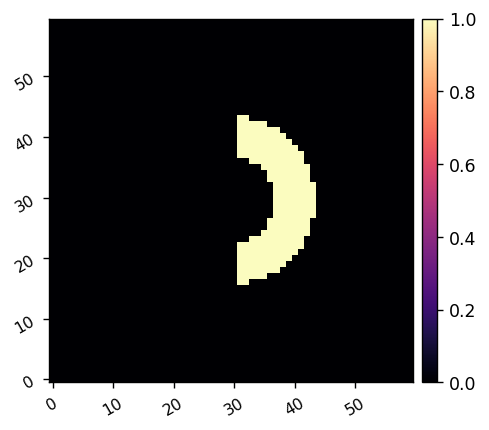

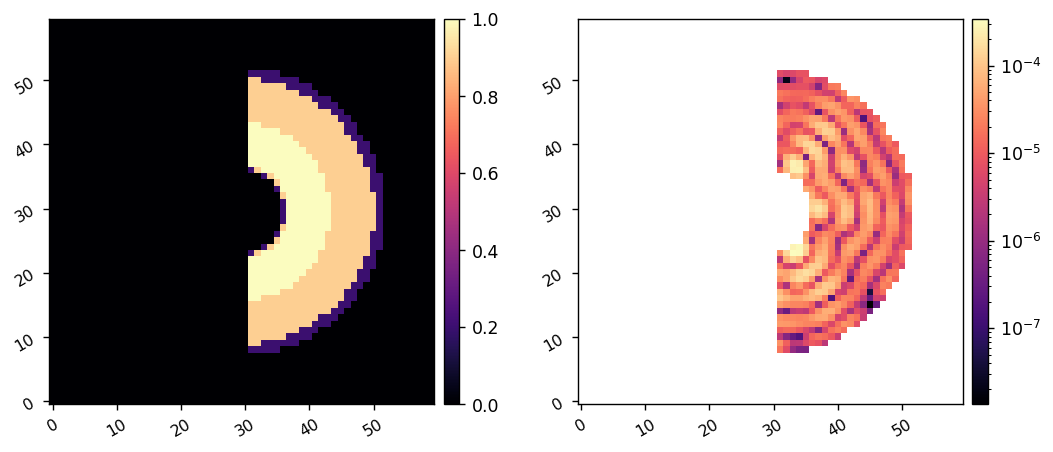

3.177583053239739e-05


In [5]:
reload(utils)
xfp = (xp.linspace(-mode.npsf/2, mode.npsf/2-1, mode.npsf) + 1/2)*mode.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 0.5,
        'rotation':0,
        'full':True,
    }
roi1 = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 0.5,
        'rotation':0,
        'full':True,
    }
roi2 = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 0.5,
        'rotation':0,
        'full':True,
    }
roi3 = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create probe and fourier modes

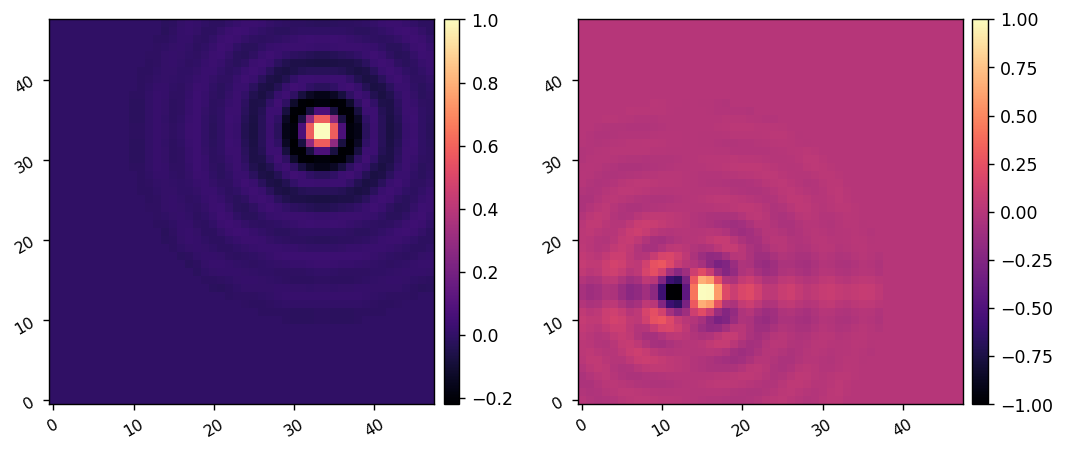

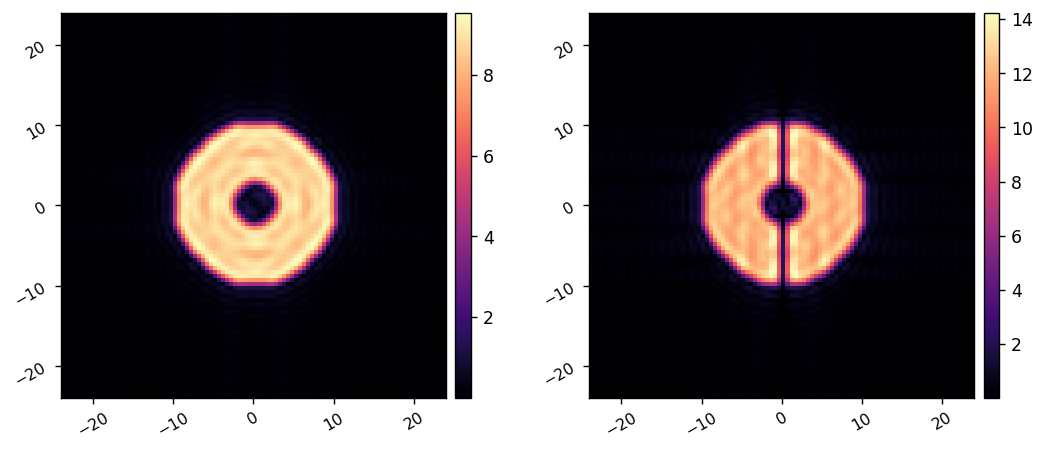

In [6]:
reload(utils)
probe_amp = 2.5e-8
fourier_modes, fs = utils.select_fourier_modes(mode, control_mask*(fpx>0), fourier_sampling=0.5) 
probe_modes = utils.create_fourier_probes(fourier_modes, shift_cos=(10,10), shift_sin=(-10,-10), plot=True)

oversamp = 2
probe_1_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[0], int(oversamp*mode.Nact)))))
probe_2_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[1], int(oversamp*mode.Nact)))))
imshow2(abs(probe_1_response), abs(probe_2_response), pxscl=1/oversamp)

In [7]:
calib_amp = 2.5e-9

calib_modes = xp.zeros((mode.Nacts, mode.Nact, mode.Nact))
count=0
for i in range(mode.Nact):
    for j in range(mode.Nact):
        if mode.dm_mask[i,j]:
            calib_modes[count, i,j] = 1
            count+=1
            
calib_modes = calib_modes[:,:].reshape(mode.Nacts, mode.Nact**2)

# import time
# for i in range(mode.Nacts):
#     try:
#         imshow1(calib_modes[i].reshape(mode.Nact,mode.Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

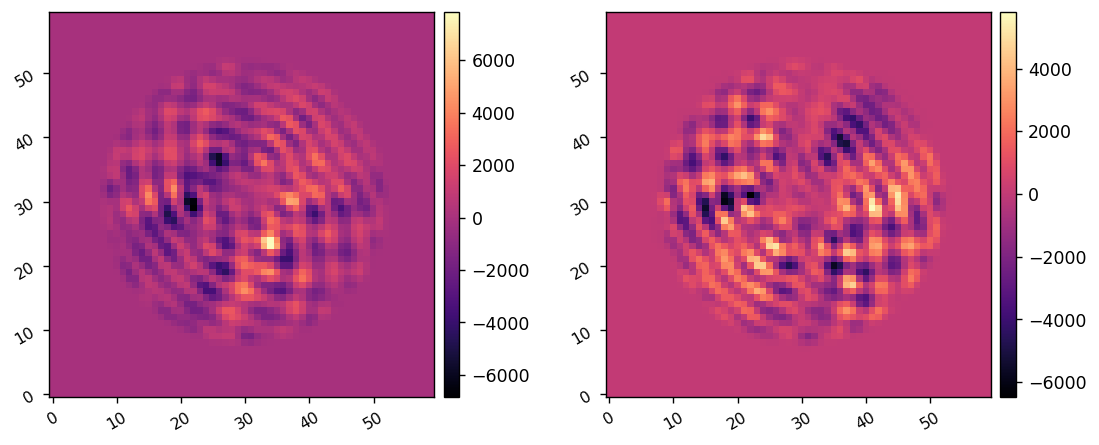

In [8]:
reload(iefc_2dm)

mode.reset_dms()

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True)
diff_ims = differential_images.reshape(2, mode.npsf, mode.npsf)
imshow2(diff_ims[0], diff_ims[1], wspace=0.35)

In [23]:
reload(iefc_2dm)
response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                control_mask,
                                                probe_amp, probe_modes, 
                                                calib_amp, utils.ensure_np_array(calib_modes), 
                                                return_all=True)


Calibrating iEFC...
	Calibrated mode 1804/1804 in 8697.246s
Calibration complete.


In [28]:
utils.save_fits(response_dir/f'hlc_iefc_2dm_poke_response_matrix_{today}.fits', ensure_np_array(response_matrix))
utils.save_fits(response_dir/f'hlc_iefc_2dm_poke_response_cube_{today}.fits', ensure_np_array(response_cube))


Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hlc_iefc_2dm_poke_response_matrix_20230726.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hlc_iefc_2dm_poke_response_cube_20230726.fits


In [8]:
# date = 20230629
# date = 20230703
date = 20230726
# date = today

response_matrix = xp.array(fits.getdata(response_dir/f'hlc_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(response_dir/f'hlc_iefc_2dm_poke_response_cube_{date}.fits'))

In [37]:
response_matrix.shape, calib_modes.shape, control_mask.sum()*2

((1372, 3608), (1804, 2304), array(1372))

# So the shape of the 

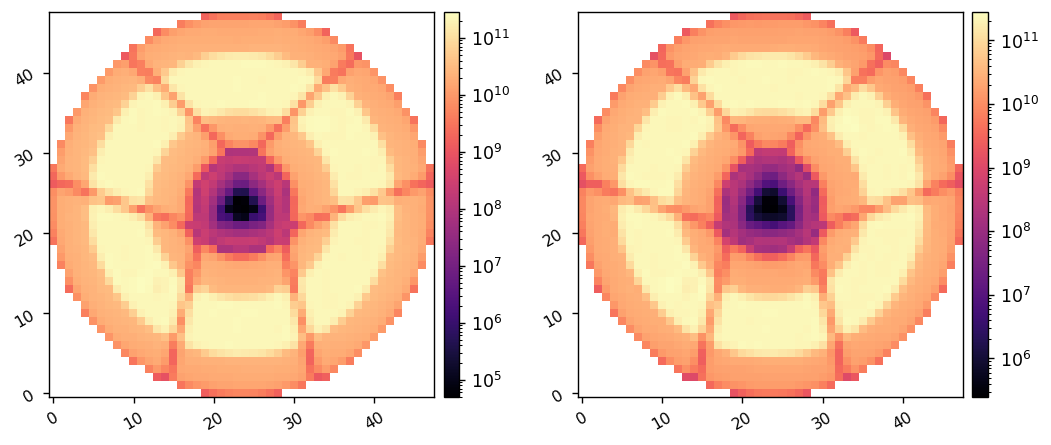

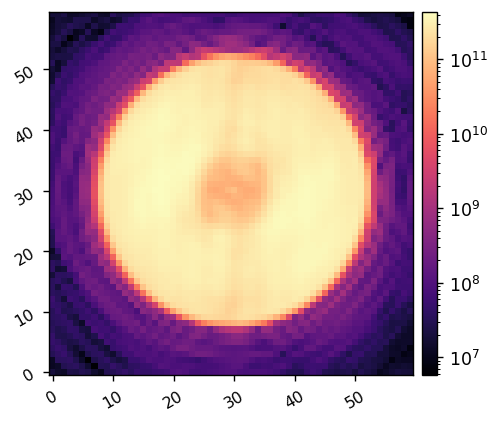

In [9]:
reload(utils)
dm1_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,:mode.Nacts]**2, axis=0)), mode.dm_mask)
dm2_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,mode.Nacts:]**2, axis=0)), mode.dm_mask)
imshow2(dm1_response , dm2_response, lognorm=True)

fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(mode.npsf, mode.npsf)
imshow1(fp_response, lognorm=True)

# Run IEFC

In [68]:
num_iterations = 30
reg_conds = np.array([1e-1, 1e-1, 1e-1, 1e-3, 1e-3])
reg_conds = np.tile(reg_conds, 6)

Running iEFC...
	Closed-loop iteration 1 / 5
	Mean NI of this iteration: 8.613e-06


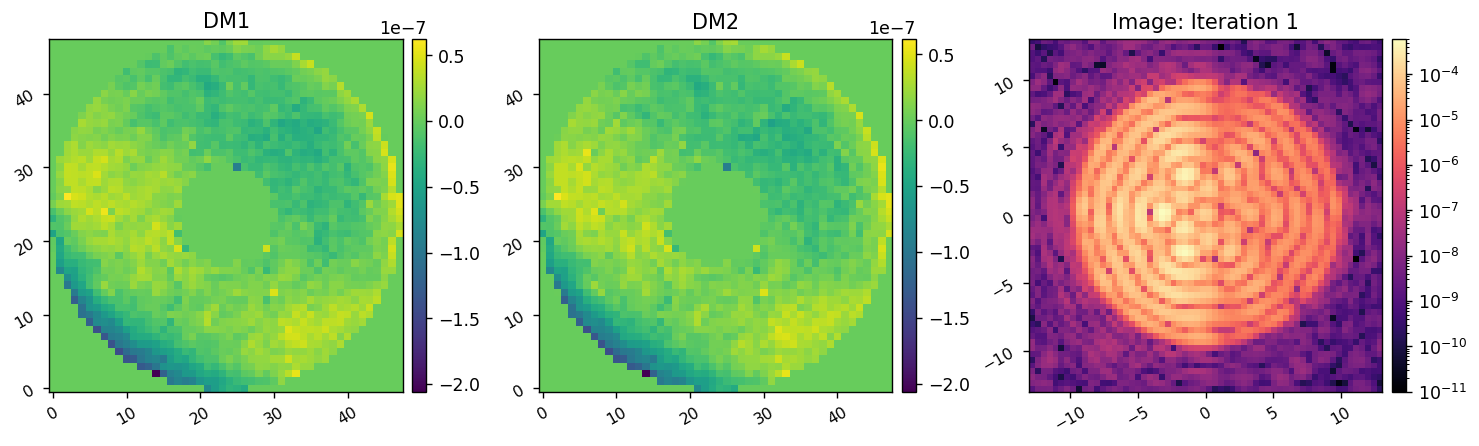

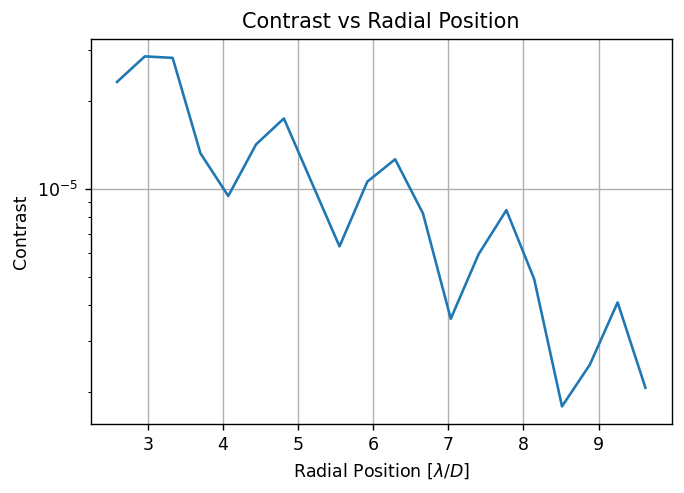

	Closed-loop iteration 2 / 5
	Mean NI of this iteration: 2.802e-06


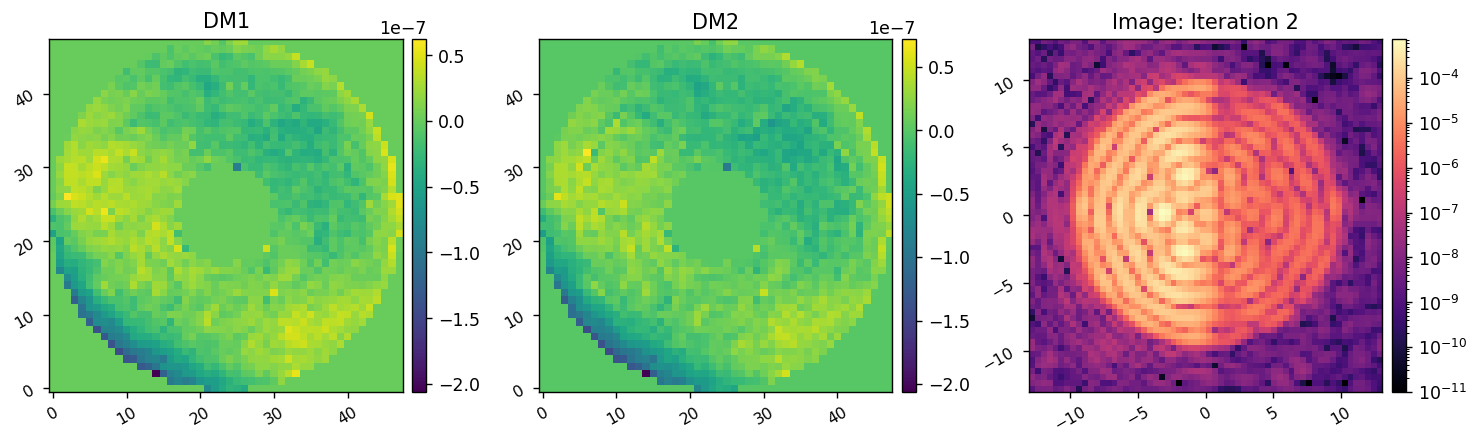

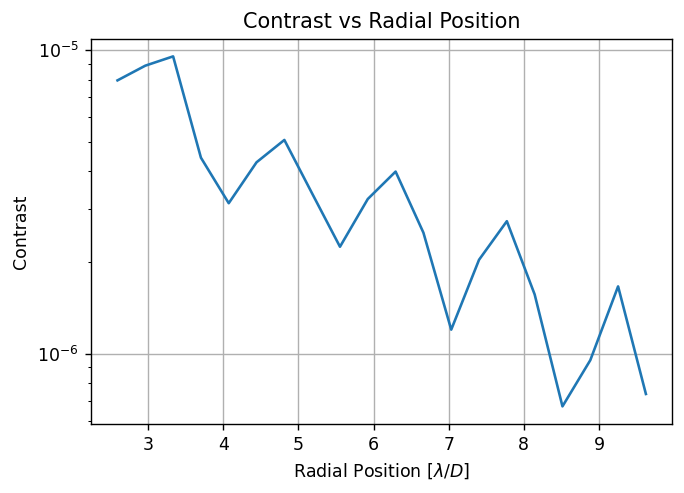

	Closed-loop iteration 3 / 5
	Mean NI of this iteration: 1.292e-06


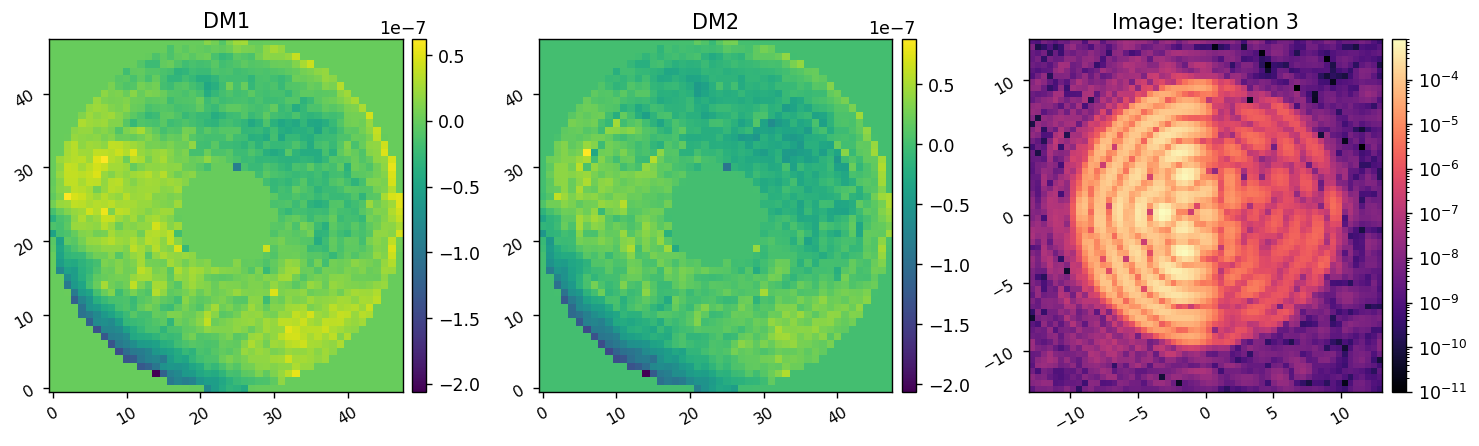

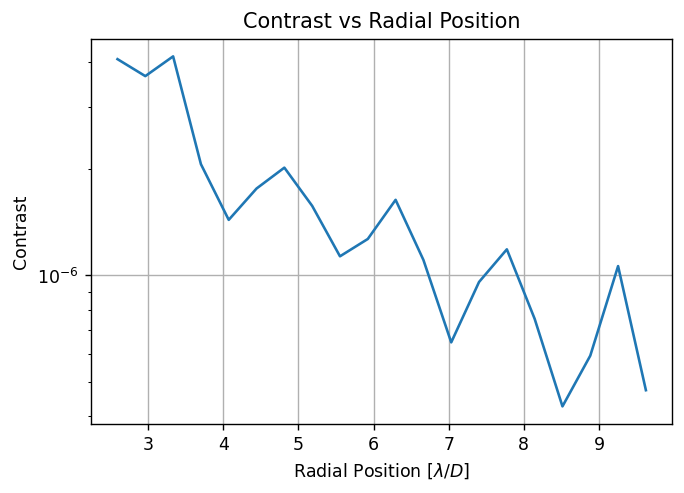

	Closed-loop iteration 4 / 5
	Mean NI of this iteration: 8.678e-07


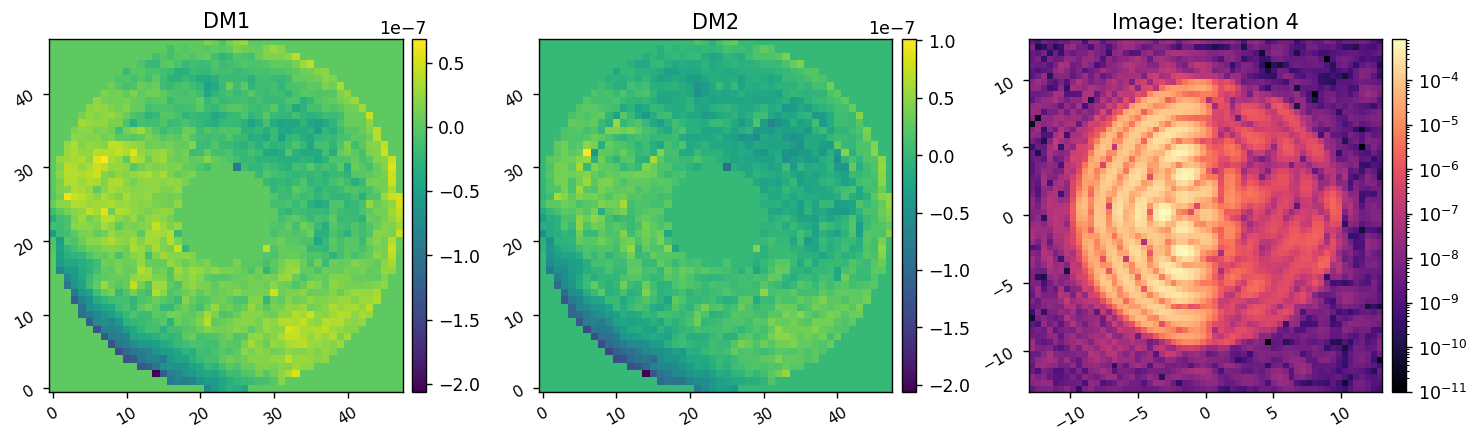

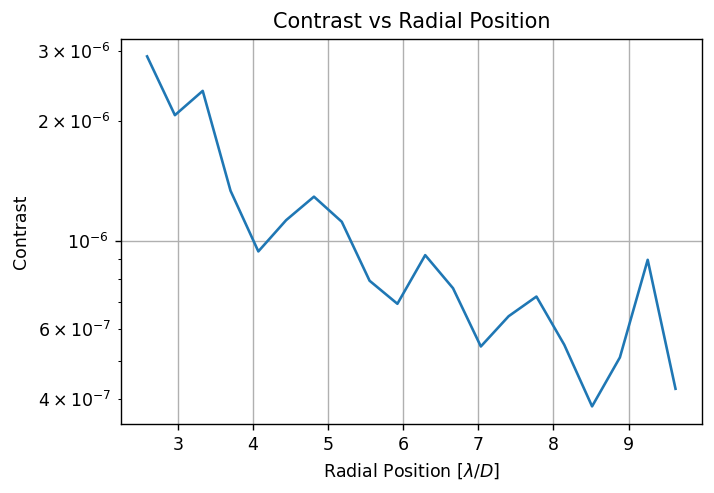

	Closed-loop iteration 5 / 5
	Mean NI of this iteration: 7.419e-07


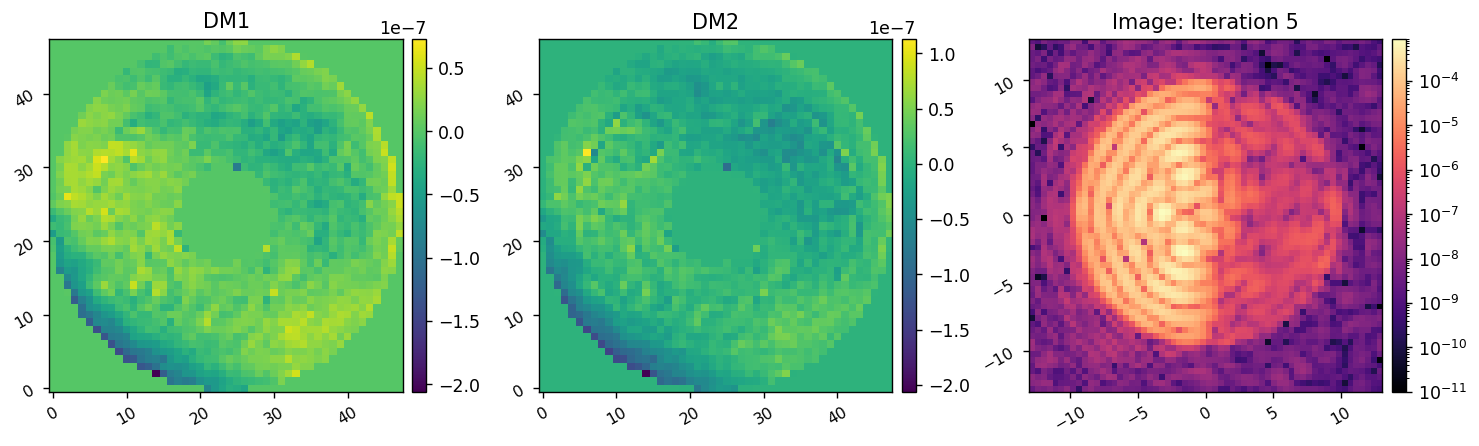

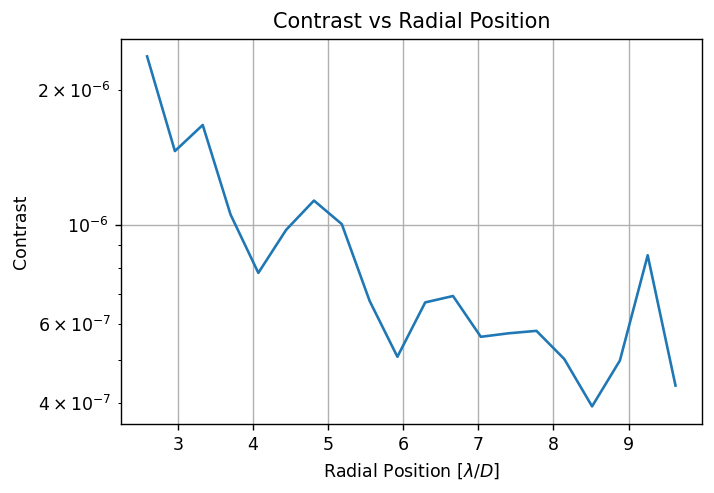

Closed loop for given control matrix completed in 11.773s.


In [17]:
reload(iefc_2dm)
reload(utils)

mode.reset_dms()

reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

In [18]:
images.shape

(5, 60, 60)

Running iEFC...
	Closed-loop iteration 6 / 10
	Mean NI of this iteration: 4.368e-07


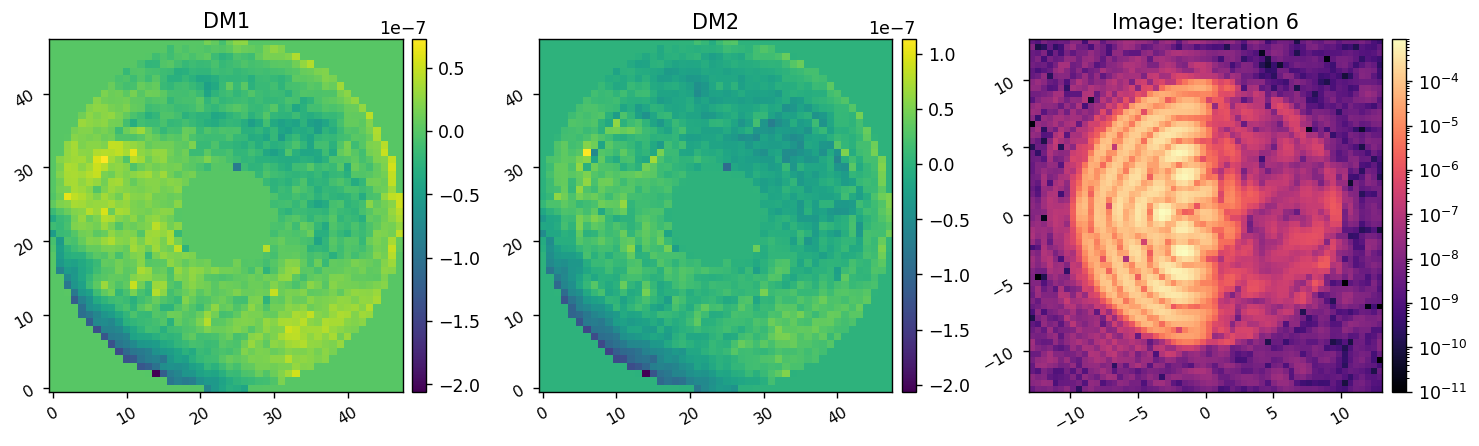

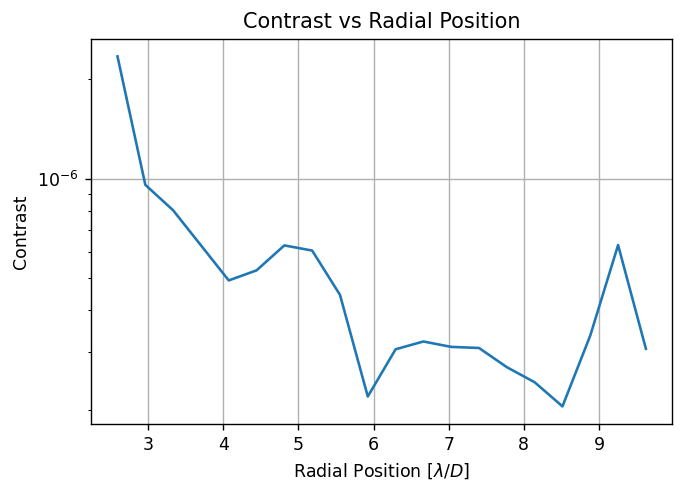

	Closed-loop iteration 7 / 10
	Mean NI of this iteration: 3.387e-07


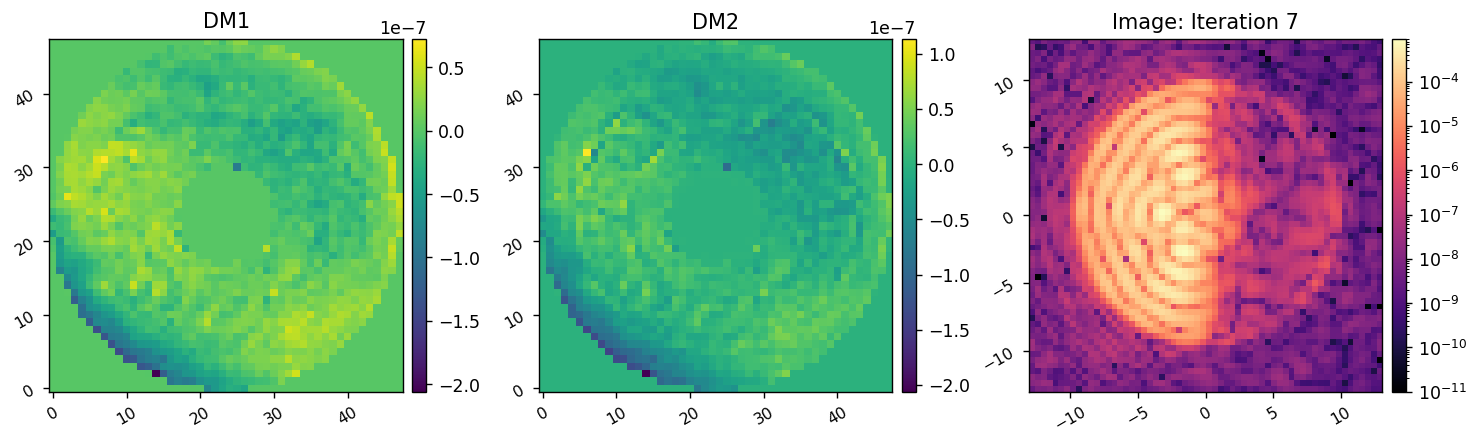

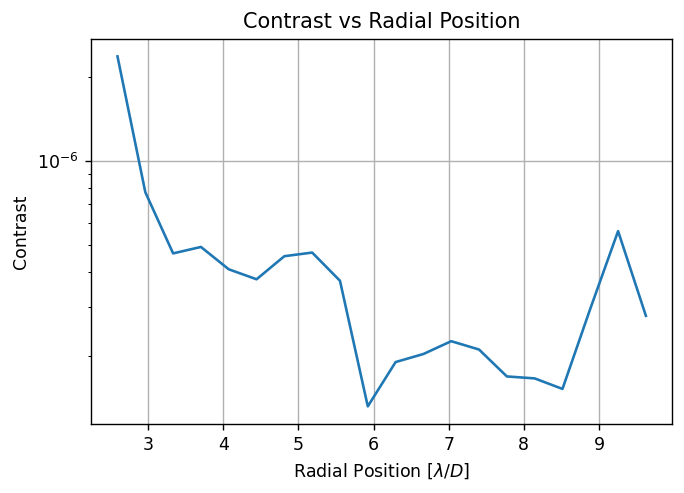

	Closed-loop iteration 8 / 10
	Mean NI of this iteration: 3.078e-07


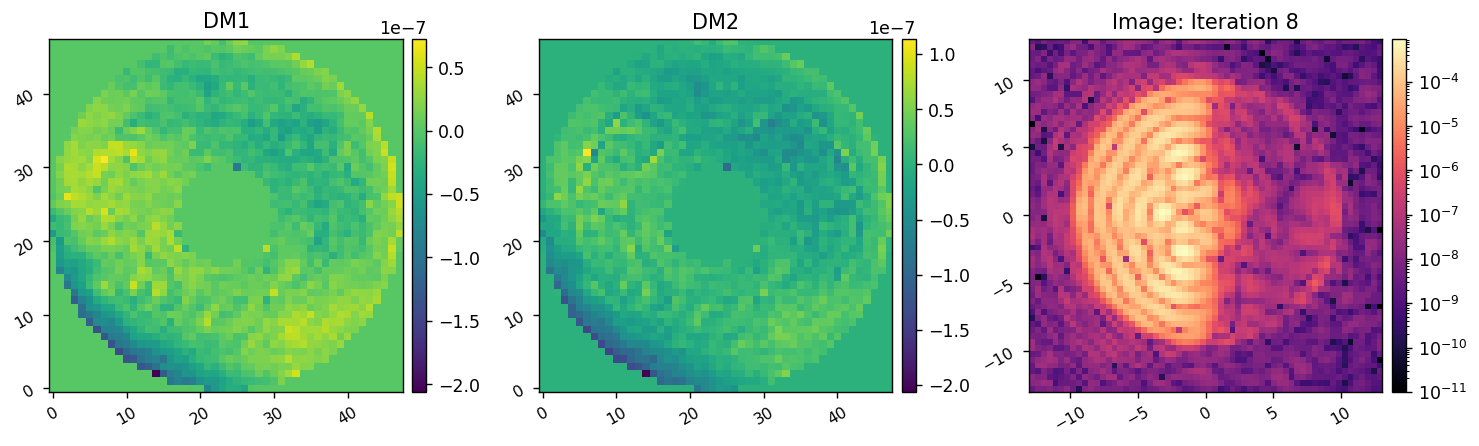

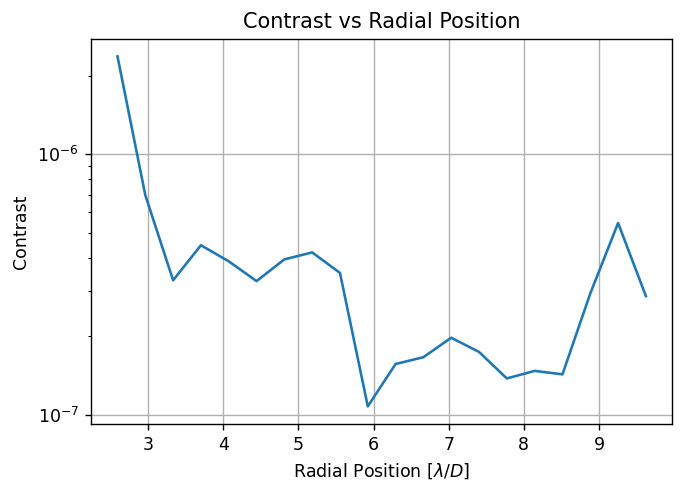

	Closed-loop iteration 9 / 10
	Mean NI of this iteration: 2.985e-07


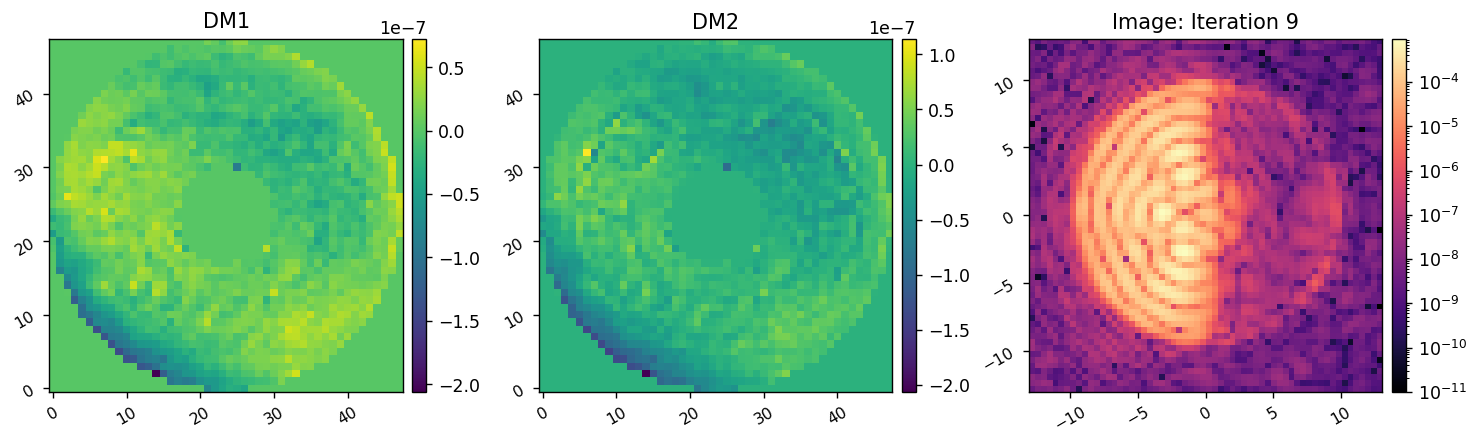

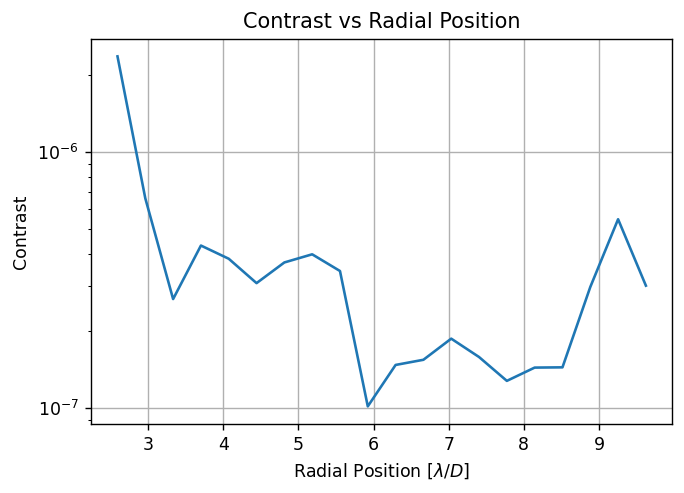

	Closed-loop iteration 10 / 10
	Mean NI of this iteration: 2.962e-07


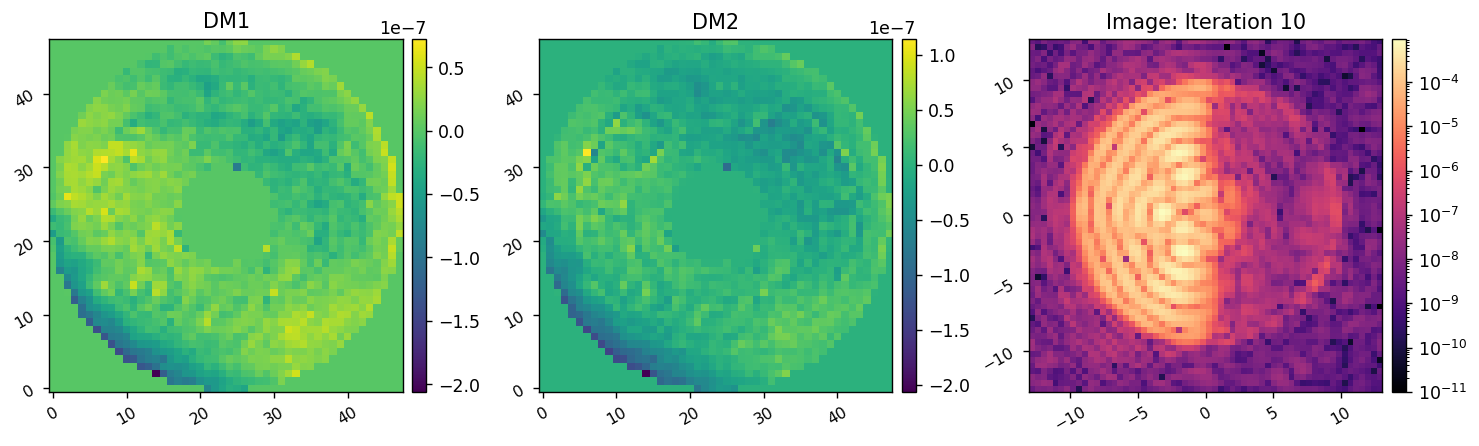

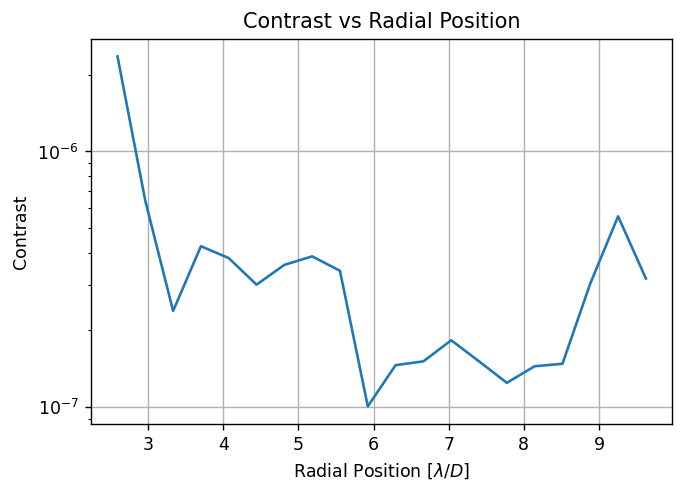

Closed loop for given control matrix completed in 11.744s.


In [19]:
reload(iefc_2dm)

Nitr = 5
reg_cond = 1e-1
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                                  control_matrix,
                                                  probe_modes, 
                                                  probe_amp, 
                                                  ensure_np_array(calib_modes),
                                                  control_mask, 
                                                  num_iterations=Nitr, 
#                                                   starting_iteration=0,
                                                  loop_gain=0.5, 
                                                  leakage=0,
                                                  plot_all=True,
                                                  plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                 )

# Run with recalibrations test

In [26]:
reg_fun = utils.WeightedLeastSquares
reg_kwargs = {
    'weight_map':weight_map,
    'nprobes':len(probe_modes),
}
num_iterations = 10
reg_conds = np.tile([1e-3, 1e-3, 0.1, 0.1, 0.1], 2)
print(len(reg_conds))
calib_iterations = np.arange(0,num_iterations,5)
print(calib_iterations)

10
[0 5]


In [32]:
reload(iefc_2dm)
images, dm1_commands, dm2_commands = iefc_2dm.run_with_recalibration(mode, 
                                                                     control_mask,
                                                                     probe_amp, probe_modes,
                                                                       calib_amp, ensure_np_array(calib_modes),
                                                                       reg_fun, 
                                                                       reg_kwargs,
                                                                       reg_conds,
                                                                     num_iterations=num_iterations,
                                                                     calib_iterations=calib_iterations,
                                                                     loop_gain=0.5,
                                                                     leakage=0.0,
                                                                     plot_all=True,
                                                                    )
                                                                     

Calibrating iEFC...


KeyboardInterrupt: 